In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-19 14:02:21.703504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*pos*.npy"))

In [6]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/VALID*pos*.npy"))

In [7]:
filename_valid = filename_neg_valid + filename_pos_valid

In [10]:
#filename_neg_train

In [9]:
#ind_pick_from_batch = [2, 11, 17, 18]

L_vars = 4
L_vars_h = 4
L_vars_ori = 19

In [11]:
L_valid = len(filename_valid)

TEST_input = np.empty((L_valid, 3, 64))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    
    collection = np.load(name, allow_pickle=True)[()]
    
    vector_gn2 = collection['Gn2']
    vector_gn1 = collection['Gn1']
    vector_gp0 = collection['Gp0']
    #vector_gp1 = collection['Gp1']
     
    TEST_input[i, 0, :] = vector_gn2
    TEST_input[i, 1, :] = vector_gn1
    TEST_input[i, 2, :] = vector_gp0
    #TEST_input[i, 3, :] = vector_gp1
    
    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [12]:
prob_base = np.sum(TEST_target) / len(TEST_target)

In [13]:
prob_base

0.003781148922600337

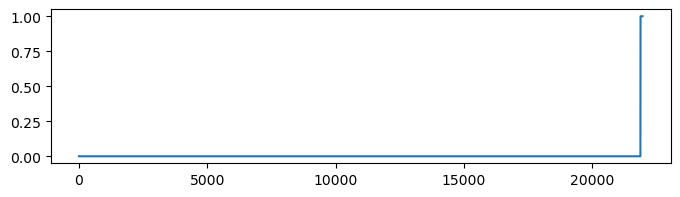

In [14]:
plt.figure(figsize=(8, 2))
plt.plot(TEST_target)

**ConvNext**

In [15]:
from sklearn.metrics import brier_score_loss

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    BS = brier_score_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{} {} {} {}'.format(CSI, AUC, freq, BS))
    metric = AUC_metric + 2*BS


    return metric


# def verif_metric(VALID_target, Y_pred, prob_base):
#     BS = np.mean((Y_pred.ravel()-VALID_target.ravel())**2)
#     BSS = 1-(BS/prob_base)
#     print('BS = {}; BSS = {}'.format(BS, BSS))
#     return BS/prob_base

In [16]:
from tensorflow.keras import Model

In [39]:
IN = tf.keras.Input(shape=(3, 64))

X = IN

X = tf.keras.layers.Conv1D(64, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(128, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

#X = tf.keras.layers.Dropout(0.1)(X)

X = tf.keras.layers.Conv1D(256, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(128, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(64, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Flatten()(X)

OUT = X

OUT = layers.Dense(64)(OUT)
OUT = layers.Activation("gelu")(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6)(OUT)

OUT = layers.Dense(1, activation='sigmoid')(OUT)

model = Model(inputs=IN, outputs=OUT)

In [40]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience
epochs = 500
L_train = 100
batch_size = 100
batch_size_half = 50

In [54]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'SEQ_3'

model_name = '{}_pp4'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'SEQ_S_pp4_tune10')

for l in range(len(W_new)):
    if W_new[l].shape == W_old[l].shape:
        W_new[l] = W_old[l]

model.set_weights(W_new)


In [55]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.Adam(lr=1e-4))

In [56]:
X_batch = np.empty((batch_size, 3, 64))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [57]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [58]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record_temp = verif_metric(TEST_target, Y_pred)
record = record_temp
print("Initial record: {}".format(record))

0.0 0.6054676911413719 0.0 0.041733613353510404
Initial record: 0.4779995355656489


In [59]:
#verif_metric(TEST_target, Y_pred, thres=0.5)

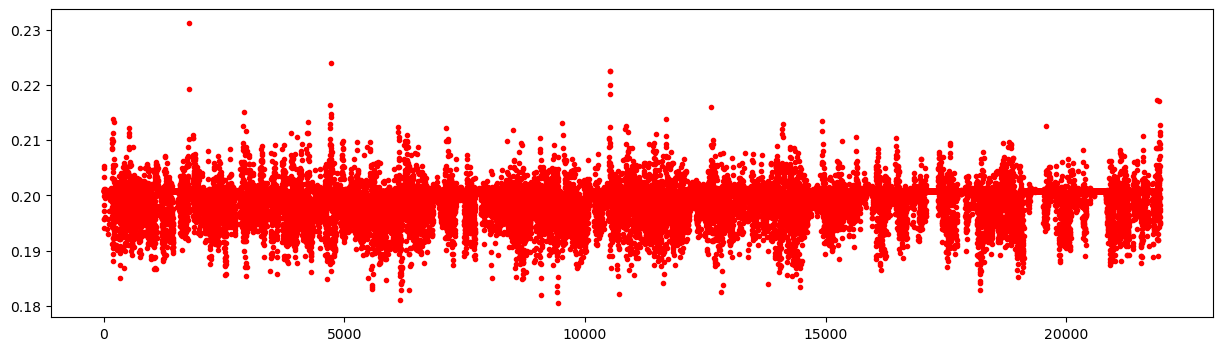

In [60]:
plt.figure(figsize=(15, 4))
#plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r.')
#plt.plot(Y_pred>0.5)

In [61]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:
# ========== Training loop ========== #



for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        N_aug = int(np.random.uniform(30, 50))
        N_storm = 100 - N_aug

        L_storm = len(filename_neg_train)
        L_aug = len(filename_pos_train)
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            collection = np.load(file_pick[k], allow_pickle=True)[()]
    
            vector_gn2 = collection['Gn2']
            vector_gn1 = collection['Gn1']
            vector_gp0 = collection['Gp0']
            #vector_gp1 = collection['Gp1']
            
            X_batch[k, 0, :] = vector_gn2
            X_batch[k, 1, :] = vector_gn1
            X_batch[k, 2, :] = vector_gp0
            #X_batch[k, 3, :] = vector_gp1

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.9999, 1.0)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.0, 0.0001)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0.0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.5):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.6947203483772295 0.0 0.003780548211041607
Validation loss 0.3128407480448537 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7285861940536978 0.0 0.0037805145131807796
Validation loss 0.27897483497266373 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.741590837467301 0.0 0.003780500374039747
Validation loss 0.26597016328077844 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.755238440500616 0.0 0.0037804979245007544
Validation loss 0.25232255534838555 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7667103387025328 0.0 0.0037805083405512033
Validation loss 0.2408506779785696 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7693766652488865 0.0 0.003780470105772999
Validation loss 0.2381842749626595 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7700245834260768 0.0 0.003780452335648072
Validation loss 0.2375363212452193 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7707278721617767 0.0 0.0037804580279673346
Validation loss 0.23683304389415794 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7740666341972977 0.0 0.0037804490256154056
Validation loss 0.2334942638539331 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7742112587904204 0.0 0.0037804122158043396
Validation loss 0.23334956564118828 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7740291695407935 0.0 0.0037803289452409132
Validation loss 0.23353148834968834 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.7739718706543753 0.0 0.003779855111391195
Validation loss 0.23358783956840706 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.23134012178217167 0.0 0.003780552506414095
Validation loss 0.7762209832306565 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.0 0.2347521602782081 0.0 0.00378056218777149
Validation loss 0.7728089640973349 NOT improved



KeyboardInterrupt



In [ ]:
model.save(model_path)

0.07216494845360824 0.8547555871923765 1.5060240963855422 0.008271191126251975

Validation loss improved from 0.16323948442990924 to 0.16178679506012741

save to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5

INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5/assets

In [ ]:
import tf.keras.backend as K

In [ ]:
def custom_loss(y_true, y_pred):
            
    y_pred_neg = y_pred[y_true == 0]
    y_pred_pos = y_pred[y_true == 1]
    
    loss = 0.1*K.mean(y_pred_neg) + K.mean(K.abs(y_pred_pos-1))
        
    return loss